# Loading the Data

First, we have to load the relational database and store it into a pandas dataframe object.  
For this I wrote a class that functions as a **Context Manager**. A Context Manager is a handy way  
in Python to manage recources like files, database access or threads for example.  
Here, we use a **DatabaseManager** to open a database connection to a specific table.  
We can then use this DatabaseManager to read the table and store it into a pandas Dataframe.

In [1]:
from readsql import DatabaseManager

pokemon_df = None
gender_df = None
label_df = None
type_df = None

with DatabaseManager('../database/pokemon.db', "Pokemon") as db: 
    pokemon_df = db.read()
    
with DatabaseManager('../database/pokemon.db', "Gender") as db: 
    gender_df = db.read()

with DatabaseManager('../database/pokemon.db', "Label") as db: 
    label_df = db.read()
    
with DatabaseManager('../database/pokemon.db', "Type") as db: 
    type_df = db.read()

### Combining all datasets

In the next step, we want to merge the different dataset. As pokemon_df, gender_df and type_df all contain unique **Dex** entries as their 
*primary key* we can easily do this by merging the three datasets and using the **Dex** entry in the *On*-clause.  

This will create a new dataset that matches each row on the left DataFrame with a row on the right DataFrame based on the **Dex** entry. Notice how I changed the **JOIN**-type from *inner* to a *left* JOIN in the second merge operation. This is necessary, because the **Label** dataset only contains label information about *Legendary*, *Mythical* and *Sub-Legendary* Pokemon. By choosing a left JOIN, we actually tell pandas to use **EVERY** row of the left DataFrame and find a corresponding row in the right DataFrame. If does not find a corresponding row, it will fill each entry in the right dataset with *NaN*.

For a Pokemon's types we actually create two seperated column called "type1" and "type2". To do this, we create a dictionary of list entries that stores a Pokemon's types in a list based on its **Dex** value.

Last but not least, we create a new column for genderless Pokemon. Here, a 1 indicates a Pokemon without a gender whereas a 0 indicates a Pokemon with either male or female gender. 

#### Hypothesis: Legendary Pokemon tend to have no gender, because they cannot reproduce.

In [2]:
pokemonGender_df = pokemon_df.merge(gender_df, left_on = "Dex", right_on = "Dex")
pokemonMaster_df = pokemonGender_df.merge(label_df, left_on = "Dex", right_on = "Dex", how = "left")

In [3]:
import numpy as np 

pokemonMaster_df["Label"] = pokemonMaster_df["Label"].apply(lambda x: "Non Legendary" if x is np.NaN else x)
pokemonMaster_df.drop(columns=["Legendary"], inplace = True)

In [4]:
from collections import defaultdict

type_dict = defaultdict(list)

for _, dex, pokeType in type_df.itertuples():
    type_dict[dex].append(pokeType)
        

In [5]:
type1 = pokemonMaster_df["Dex"].apply(lambda x: type_dict[x][0])
type2 = pokemonMaster_df["Dex"].apply(lambda x: type_dict[x][1] if len(type_dict[x]) == 2 else None)

pokemonMaster_df["Type1"] = type1
pokemonMaster_df["Type2"] = type2

pokemonMaster_df["Type2"] = pokemonMaster_df["Type2"].fillna("None") 

In [6]:
def f(x):
    return not(x[0] or x[1])

pokemonMaster_df["Genderless"] = pokemonMaster_df[["Male", "Female"]].apply(f, axis = 1)

In [7]:
pokemonMaster_df.columns

Index(['Dex', 'Name', 'Hp', 'Atk', 'Def', 'Satk', 'Sdef', 'Spd', 'Total',
       'Height', 'Weight', 'Growthr', 'Catchr', 'Gen', 'Female', 'Male',
       'Femaler', 'Maler', 'Label', 'Type1', 'Type2', 'Genderless'],
      dtype='object')

In [8]:
pokemonMaster_df.sample(10)

,Dex,Name,Hp,Atk,Def,Satk,Sdef,Spd,Total,Height,...,Catchr,Gen,Female,Male,Femaler,Maler,Label,Type1,Type2,Genderless
262,263,Zigzagoon,38,30,41,30,41,60,240,0.4,...,255.0,Ruby,1,1,50.0,50.0,Non Legendary,Normal,Dark,False
291,292,Shedinja,1,90,45,30,30,40,236,0.8,...,45.0,Ruby,0,0,0.0,0.0,Non Legendary,Bug,Ghost,True
128,129,Magikarp,20,10,55,15,20,80,200,0.9,...,255.0,Red,1,1,50.0,50.0,Non Legendary,Water,None,False
589,590,Foongus,69,55,45,55,55,15,294,0.2,...,190.0,Black,1,1,50.0,50.0,Non Legendary,Grass,Poison,False
662,663,Talonflame,78,81,71,74,69,126,499,1.2,...,45.0,X,1,1,50.0,50.0,Non Legendary,Fire,Flying,False
723,724,Decidueye,78,107,75,100,100,70,530,1.6,...,45.0,Sun,1,1,12.5,87.5,Non Legendary,Grass,Ghost,False
193,194,Wooper,55,45,45,25,25,15,210,0.4,...,255.0,Gold,1,1,50.0,50.0,Non Legendary,Water,Ground,False
736,737,Charjabug,57,82,95,55,75,36,400,0.5,...,120.0,Sun,1,1,50.0,50.0,Non Legendary,Bug,Electric,False
613,614,Beartic,95,130,80,70,80,50,505,2.6,...,60.0,Black,1,1,50.0,50.0,Non Legendary,Ice,None,False
417,418,Buizel,55,65,35,60,30,85,330,0.7,...,190.0,Diamond,1,1,50.0,50.0,Non Legendary,Water,None,False


# Exploring the Data

Next, we wanna actually take a look into the data. In a professional data science project you would have to split the  
dataset into a training and a test set now. In our little project however, we do not use this approach and instead look at the whole dataset.

For this purpose we define different subsets of the Data.  
It can be devided as follows:

1. Numerical Columns
2. Stat Columns
3. Categorical Columns
4. The target variable

Many Machine Learning techniques cannot deal well with categorical data. The same applies for different visualization techniques.  
For this reason, we define different subsets. We even create a special subset for a Pokemon's stats only.

In [9]:
numCols = ["Hp", "Atk", "Def", "Satk", "Sdef", "Spd", "Height", "Weight", "Catchr", "Femaler", "Maler"]
statCols = ["Hp", "Atk", "Def", "Satk", "Sdef", "Spd"]

catCols = ["Gen", "Type1", "Type2", "Growthr", "Male", "Female", "Genderless"]
target = ["Label"]

## Using Histograms and Scatterplot to explore numerical variables

Seaborn offers an incredible way to plot all variables at once.  
Here, we use the pairplot to plot each stat against the other.  The figures are  
displayed in a tabular layout. Each column and row represents a different variable.  
This way, you can plot ATK again HP, for example. For cases where you plot a variable against  
itself, a Histogram is shown instead.

So, what can we tell about the stat's distributions?

It seems like that HP and ATK are somehow related, with Pokemon having more HP with an increasing ATK stat.  
The same applies to ATK and DEF, SATK and SDEF and maybe even SATK and SPD.  
Based on the histograms we can tell, that stats are usually left skewed. That means, lots of Pokemon tend to have
lower stats while few ones have high stats.

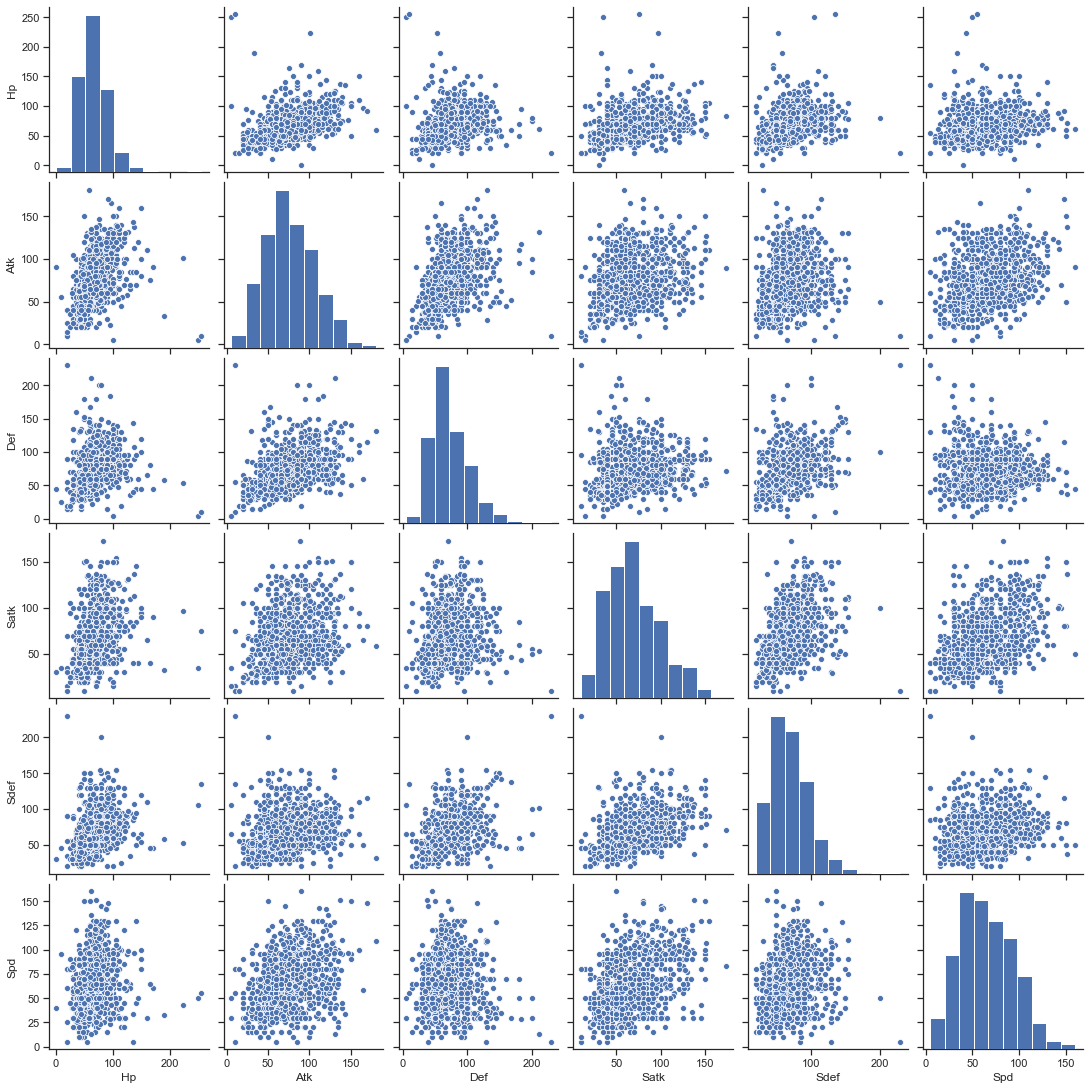

In [10]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)

sns.pairplot(pokemonMaster_df[statCols])

## Dinstinction between different Pokemon classes

Let's look at the same plot, but this time color coded by different Pokemon classes.  
Remember that each Pokemon can either be Non-Legendary, Sub-Legendary, Mythical or Legendary.

Below we can tell that Non-Legendary (blue) Pokemon tend to have smaller stat values. Especially,   
when looking at the ATK Stat. One can see from the KDE (Kernel density estimation) plot that Non-Legendary  
Pokemon tend to have an expected value of 50 ATK while Legendary Pokemon have an expected value of 150.

This helps us form another hypothesis to distinct legendarys from non legendarys:

### Legendary Pokemon tend to have higher stats than Non-Legendary Pokemon

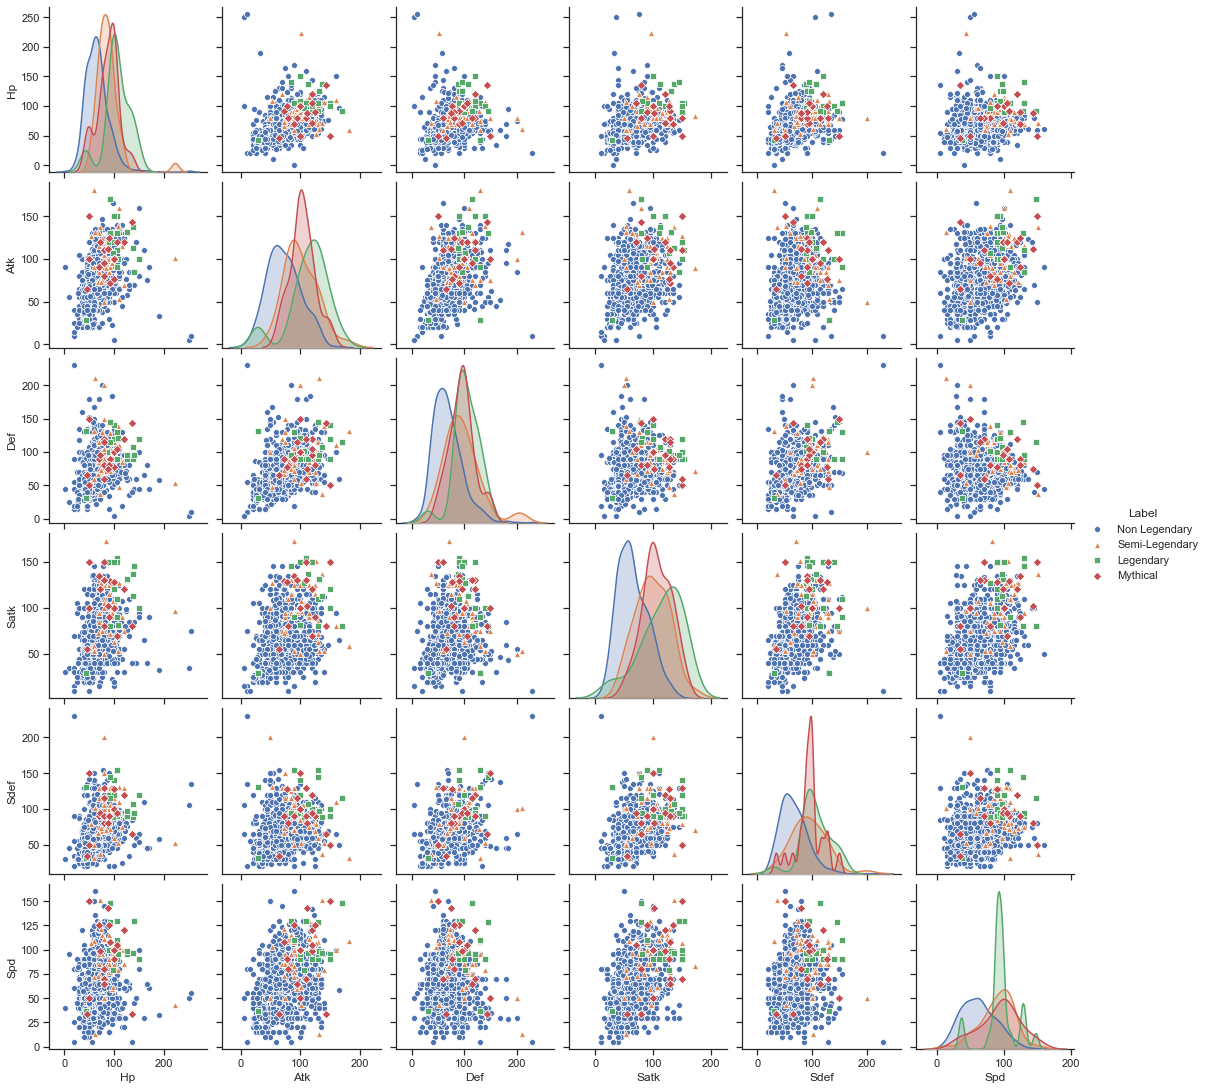

In [15]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(style="ticks", color_codes=True)

sns.pairplot(pokemonMaster_df[statCols + target], hue = "Label", markers = ["o", "^", "s", "D"])

plt.savefig("../figures/pairplot_hue_coded.pdf")

In [16]:
pokemonMaster_df[pokemonMaster_df["Def"] == pokemonMaster_df["Def"].max()]

,Dex,Name,Hp,Atk,Def,Satk,Sdef,Spd,Total,Height,...,Catchr,Gen,Female,Male,Femaler,Maler,Label,Type1,Type2,Genderless
212,213,Shuckle,20,10,230,10,230,5,505,0.6,...,190.0,Gold,1,1,50.0,50.0,Non Legendary,Bug,Rock,False


## Correlograms

We can try and varify our assumptions above with something called correlation. Instead of providing a table we will instead  
use a plot called **Correlogram**. Here the colors denote how much two variables are correlated and whether the correlation  
is negative or postive. The pearson correlation coefficient lies in [-1, 1].

We can see that especially ATK and HP, ATK and DEF, SDEF and DEF as well as SDEF and SATK correlate  
strongly with eachother. 

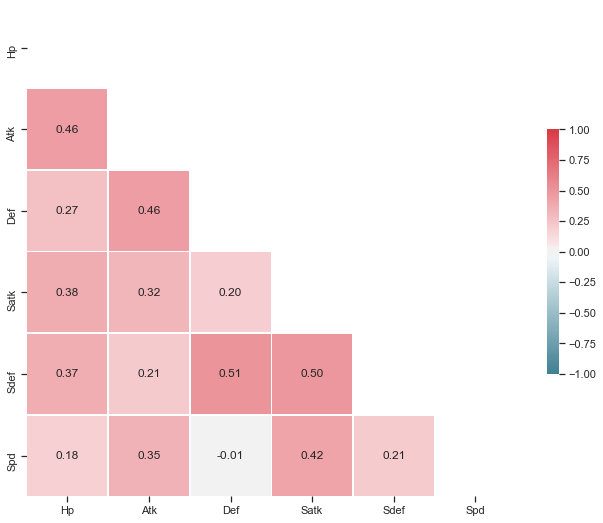

In [17]:
import matplotlib.pyplot as plt
# Compute the correlation matrix
corr = pokemonMaster_df[statCols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin = -1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True, fmt = ".2f")

plt.savefig("../figures/correlogram.pdf")

## Violin plots

Like boxplots violin plots give an insight in the distribution of a numerical variable among our samples.  
It's a combination of a boxplot and a kde plot as it shows how the actual values vary among the corresponding axes.

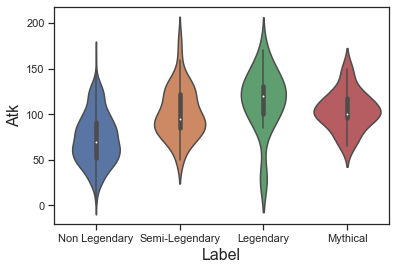

In [18]:
sns.violinplot(x = pokemonMaster_df["Label"], y = pokemonMaster_df["Atk"] )
plt.xlabel("Label", fontsize = 16)
plt.ylabel("Atk", fontsize = 16)
plt.savefig("../figures/violine_atk.pdf")

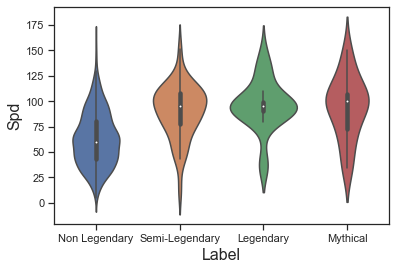

In [19]:
sns.violinplot(x = pokemonMaster_df["Label"], y = pokemonMaster_df["Spd"] )
plt.xlabel("Label", fontsize = 16)
plt.ylabel("Spd", fontsize = 16)
plt.savefig("../figures/violine_spd.pdf")
#Maybe t-test

## Height and Weight Distribution

Next, we choose a simple boxplot to take a closer look at a Pokemon's height and weight.  
We can immeadiately see, that Legendary Pokemons tend to larger than other Pokemon. This applies to the  
weight as well. On Average Legendary Pokemon tend to be 2 metres larger and weight around 100 kilogramm more than  
normal ones. We can also tell, that mythical Pokemon tend to be smaller and very lightweight.

This leads to two hypothesises: 
### 1. Legendarys and Sub-Legendarys are larger in size and weight than normal Pokemon. 
### 2. Mythical Pokemon are light-weight Pokemon.

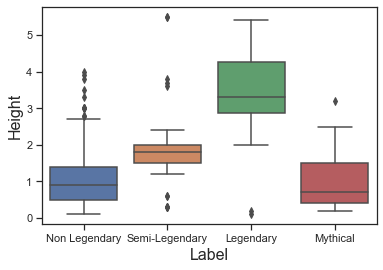

In [20]:
filteredData = pokemonMaster_df[pokemonMaster_df["Height"]<pokemonMaster_df["Height"].quantile(0.99)]
sns.boxplot(x = filteredData["Label"], y = filteredData["Height"] )
plt.xlabel("Label", fontsize = 16)
plt.ylabel("Height", fontsize = 16)
plt.savefig("../figures/boxplot_height.pdf")

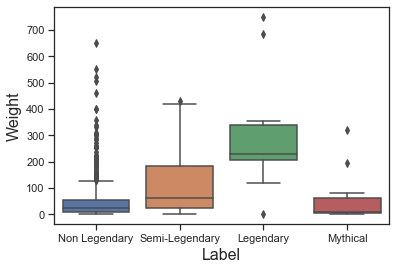

In [21]:
filteredData = pokemonMaster_df[pokemonMaster_df["Weight"]<pokemonMaster_df["Weight"].quantile(0.99)]
sns.boxplot(x = filteredData["Label"], y = filteredData["Weight"])

plt.xlabel("Label", fontsize = 16)
plt.ylabel("Weight", fontsize = 16)
plt.savefig("../figures/boxplot_weight.pdf")

In [23]:
pokemonMaster_df[numCols].describe()

,Hp,Atk,Def,Satk,Sdef,Spd,Height,Weight,Catchr,Femaler,Maler
count,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000
mean,68.768197,76.469205,71.908175,69.522956,69.886898,65.736842,1.182979,63.905711,88.494961,35.330347,43.295073
std,25.852484,29.747450,29.598859,29.308640,27.108476,28.068845,1.236524,119.815054,77.861044,25.568427,28.687136
min,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,0.100000,0.100000,-1.000000,0.000000,0.000000
25%,50.000000,55.000000,50.000000,46.000000,50.000000,45.000000,0.500000,8.500000,45.000000,12.500000,25.000000
50%,65.000000,75.000000,67.000000,65.000000,65.000000,65.000000,1.000000,27.000000,55.000000,50.000000,50.000000
75%,80.000000,95.000000,90.000000,90.000000,85.000000,85.000000,1.500000,64.800000,125.000000,50.000000,50.000000
max,255.000000,181.000000,230.000000,173.000000,230.000000,160.000000,20.000000,999.900000,255.000000,100.000000,100.000000


## Genderless Distribution

Below, we can see a bar chart displaying the genderless distribution among different classes of Pokemon. 
We can immediately see that all Legendary and all Mythical Pokemon are genderless. On the other hand only 80% of  
Sub-Legendary Pokemon are genderless. This number is much smaller however, when looking at Non Legendary Pokemon. Here,   
it is only 15%.

Based on these findings we can try something interessting:  
Let's write a classifier that predicts a legendary Pokemon when the given Pokemon is genderless.  

For this, we will combine Sub-Legendary, Legendary and Mythical Pokemon to one class called "Legendary" (encoded with 1). 
Non Legendary Pokemon will be encoded with 0.


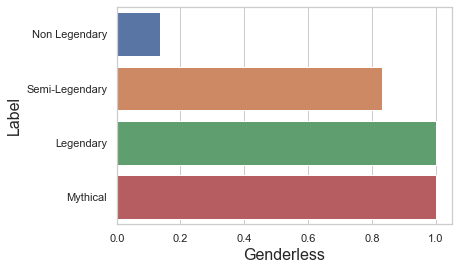

In [24]:
sns.set_style("whitegrid")
sns.barplot(x=pokemonMaster_df["Genderless"], y=pokemonMaster_df["Label"], ci = None)
plt.xlabel("Genderless", fontsize = 16)
plt.ylabel("Label", fontsize = 16)
plt.savefig("../figures/bar_genderless.pdf")

In [25]:
label_dict = {"Legendary" : 1, "Mythical" : 2, "Semi-Legendary" : 3, "Non Legendary" : 0}
labels = pokemonMaster_df["Label"].apply(lambda x: label_dict[x])


def simpleClassifier(genderless = None):
    return genderless


labels = [0  if x == 0 else 1 for x in labels]

In [26]:
prediction = pokemonMaster_df["Genderless"].apply(simpleClassifier)

np.mean(labels == prediction)

0.8689809630459127

Our classifier manages a accuracy of 86.9%. Not bad! 
More complex approaches have to perform better than that or else we can just discard them.

## Dimensionality Reduction

Sometimes a dataset can contain thousand of features (columns which we use to predict another column). 
Features for a fish, for example, could be length, weight, color, amount of fins, etc. In some cases, we  
can try to decrease the number of features. Cases might be: 
1. Fast calculation: The less features a machine learning algorithm has the faster it can compute a solution 
2. Visualization: We can only see 2D plots well. So, reducing the features can help us visualize a high-dimensional dataset

The most common dim-reduction technique is called Principle-Component-Analysis (PCA). We actually transform our data into   
another feature-space which tries to explain the variance with new coordinate axes. 

Here, we use Linear-Discriminant-Analysis. In contrast to PCA, it actually take into the class information and returns  
n - 1 new features where n is the number of classes.

<AxesSubplot:>

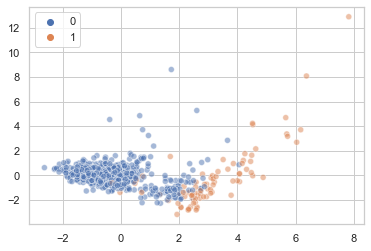

In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)

x_lda = lda.fit_transform(pokemonMaster_df[numCols], y = pokemonMaster_df["Label"])

sns.scatterplot(x_lda[:,0], x_lda[:, 1], hue=labels, alpha = 0.5)

## Analyzing Type-Coocurrence

Another thing, that is worth investigating, is the coocurrence of several type combinations.  
For this, we can create something called a **coocurrence matrix**. This matrix is commonly used  
in computer vision to determine the coocurrence of grey values in a grey scale picture.  
Here, we construct a two dimensional dictionary where each key represents the first and second  
type of a given Pokemon. One can then access the dictionary d like d["type1"]["type2"]. For each  
combination we count how often they occur together on a single Pokemon. However,  
there is a special case for Pokemon with no secondary type. We will refer to this key as the "None" key.  
Finally one can choose to normalize the values by deviding by the occurence of the less frequent type.  
That is, a type can only occur as much with another type as the other types occurence and wise-versa.  
The number then denotes the percentage of the given *less frequent* type that occurs with the other
*more frequent* type.  
The normalized coocurrence lies in [0, 1] where 0 means no coocurrence and 1 that one type only occurs with  
the other.

In [28]:
from collections import Counter

typeCnt = Counter(np.hstack([pokemonMaster_df["Type1"], pokemonMaster_df["Type2"]]))

In [29]:
sorted(typeCnt.items(), key = lambda x: x[1])

[('Ice', 45),
 ('Ghost', 50),
 ('Electric', 56),
 ('Fairy', 56),
 ('Dragon', 57),
 ('Steel', 58),
 ('Fighting', 63),
 ('Dark', 63),
 ('Rock', 65),
 ('Ground', 68),
 ('Poison', 69),
 ('Fire', 74),
 ('Bug', 84),
 ('Psychic', 92),
 ('Flying', 104),
 ('Grass', 106),
 ('Normal', 115),
 ('Water', 141),
 ('None', 420)]

In [30]:
def cstrComat(a, b, normalized = True):
    import pandas as pd 
    
    typeCnt = Counter(np.hstack([a, b]))
    #typeCnt["None"] = typeCnt.pop(None)
    type_names = typeCnt.keys()
    #type_names = [t if t is not None else "None" for t in type_names]
    
    co_dict = defaultdict(dict)
    
    for type1 in type_names:
        type1 = "None" if type1 is None else type1
        for type2 in type_names:
            type2 = "None" if type2 is None else type2
            co_dict[type1][type2] = 0
            
    for t1, t2 in zip(a, b):
        t1 = "None" if t1 is None else t1
        t2 = "None" if t2 is None else t2
        co_dict[t1][t2] += 1
        co_dict[t2][t1] += 1
    
    if normalized:
        for key1 in co_dict:
            for key2 in co_dict[key1]:
                #print(typeCnt[key1], typeCnt[key2])
                co_dict[key1][key2] /= (max(min(typeCnt[key1], typeCnt[key2]), 1))
    
    #print(co_dict["Psychic"])
    
    l = [list(i.values()) for i in co_dict.values()]
    
    #print(l)
    
    co_df = pd.DataFrame(l, columns = co_dict.keys(), index = co_dict.keys())
    
    return co_df
                    


In [31]:
d = cstrComat(pokemonMaster_df["Type1"], pokemonMaster_df["Type2"], normalized=True)

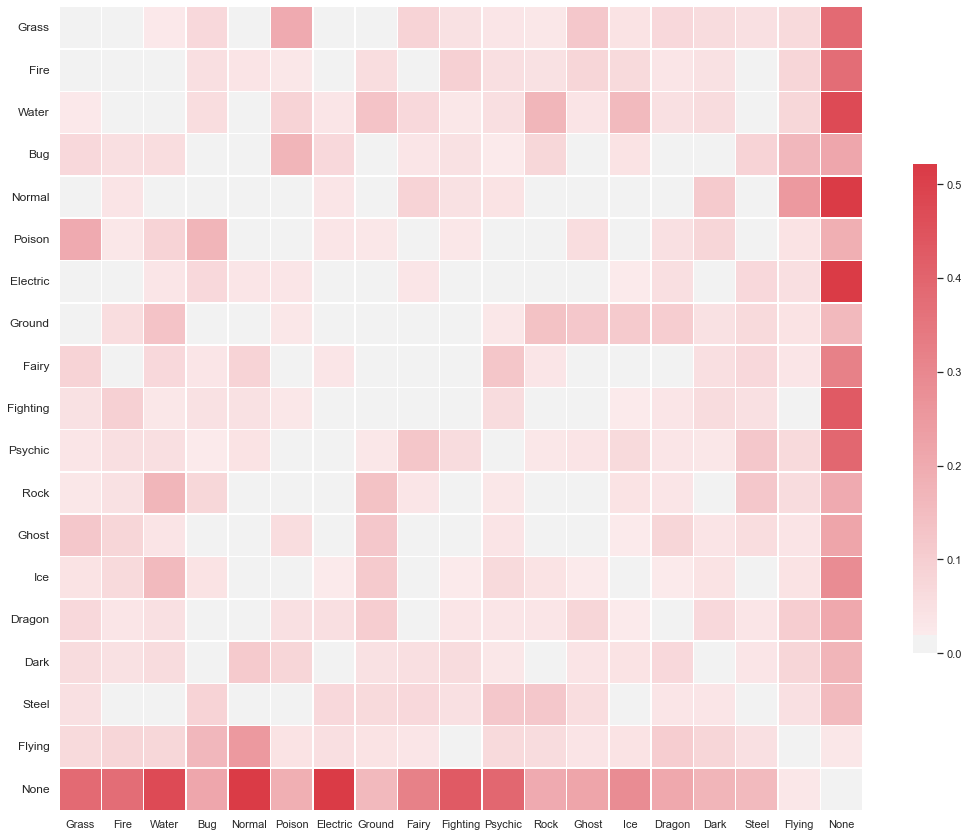

In [40]:
# Draw the heatmap with the mask and correct aspect ratio
f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(d, cmap=cmap, vmax=d.max(axis=0).max(), vmin = 0.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = False, fmt = ".2f")
_, _ = plt.yticks(np.arange(len(d.index))+0.5, d.index, rotation=0, va="center", fontsize = 12)

plt.savefig("../figures/type_heatmap.pdf")

## Constructing a type network
We can use the afor mentioned approach to use the coocurrence to construct a network.  
In this network nodes are given by types and edges define the similarity between two types.  
For the edge weights we calculate an adjusted jaccard coefficient. The jaccard coefficient defines   
the similarity between two sets. In this case each type has a set of Pokemon that it belongs to. 
For example, the fire set will look like
> fire = {"Charmander", "Hopplo", "Entei", ...}

We can then compare two types as follows:

> J_{t1, t2} = \frac{|s_{t1} \cap s_{t2}|}{|s_{t1}|} + \frac{|s_{t1} \cap s_{t2}|}{|s_{t2}|}

where t1 and t2 are the types respectively and s_{t} is the set given by type t.  
This will be 2 if type1 and type2 always occur together and 0 if they never occur together. 

We can then filter out small edge weights and only keep the 25% most important edges per nodes.

In [41]:
typeCmb_df = cstrComat(pokemonMaster_df["Type1"], pokemonMaster_df["Type2"], normalized = False) 

typeCmb_df["None"] = 0

typeCmb_df.loc["None"] = 0

typeCmb_df.drop(columns = ["None"], inplace = True)
typeCmb_df.drop(index="None", inplace = True)

typeFreq = typeCmb_df.sum()

nodes = typeCmb_df.index.values
edge_d = defaultdict(dict)

for t1 in typeCmb_df.index:
    for t2 in typeCmb_df.index:
        edge_d[t1][t2] = typeCmb_df.loc[t1, t2] / (typeFreq.loc[t1]) + typeCmb_df.loc[t1, t2] / (typeFreq.loc[t2])
        if not(edge_d[t1][t2]):
            edge_d[t1].pop(t2)

In [42]:
from pyvis.network import Network

ntypes = len(nodes)

net = Network(notebook = False, directed=False, width = 750, height = 750)

color_map = {
                "Bug" : "#A8B820",
                "Dark" : "#705848",
                "Dragon" : "#7038F8",
                "Electric" : "#F8D030",
                "Fairy" : "#EE99AC",
                "Fighting" : "#C03028",
                "Fire" : "#F08030",
                "Flying" : "#A890F0",
                "Ghost" : "#705898",
                "Grass" : "#78C850", 
                "Ground" : "#E0C068", 
                "Ice" : "#98D8D8",
                "Normal" : "#A8A878",
                "Poison" : "#A040A0",
                "Psychic" : "#F85888",
                "Rock" : "#B8A038",
                "Steel" : "#B8B8D0",
                "Water" : "#6890F0",
            }
color_list = [color_map[type] for type in nodes]


for _label, _label, _color in zip(range(len(nodes)), nodes, color_list):
    net.add_node(_label, label = _label, color = _color, shape = "circle", title = "")
#net.add_nodes(, label = nodes, color = color_list)

#nodeID_map = {node["label"] : node["id"] for node in net.nodes}


for t1, _dict in edge_d.items():
    for t2, w in sorted(_dict.items(), key = lambda x: x[1], reverse = True)[:int(ntypes*0.25)]:
        if w > 0:
            net.add_edge(t1, t2, weight = w*10, width = w*10, value = w)

In [43]:
net.show_buttons(filter_=['physics'])
neighbor_map = net.get_adj_list()

# add neighbor data to node hover data
for node in net.nodes:
    node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
    node["value"] = len(neighbor_map[node["id"]])
                                 
net.show("../figures/pokeTypes.html")

## Stat spread by Type

Another thing that might not be mandatory to distinct Legendary and Non-Legendary Pokemon is the stat spread among different  
type of Pokemons. We can use Boxplots for each type and look at examples like ATK, SPD and SATK.  
We can immediately see that Fighting Pokemon have a high ATK value, followed by Ground and Dragon Pokemon. Fairies,  
however, tend to have smaller ATK values together with Psychic Pokemon.  
This is the opposite for SATK. Here, Psychic Pokemon outshine the others.  
When looking at the SPD stat, we can tell that Electric type Pokemon tend to be faster than their close neighbours the  
Flying Pokemon.  

By looking at the height and weight distribution among different type of Pokemon, we can tell that fairies and grass Pokemon  
tend to be little light weighted Pokemon whereas steel and rock Pokemon weight the most. Dragons, however, seem to win  
height competition. 

We then can look at the ATK distribution further devided by Pokemon Labels. The difference in ATK might be soley given by the amount  
of strong Legendarys in the given type category. Earlier we showed that Legendarys tend to have higher that values. However, 
by looking at the finer distribution we cannot make this conclusion. It stands to reason, that the spread of ATK and possibly other  
stats among different typings is a general observation.

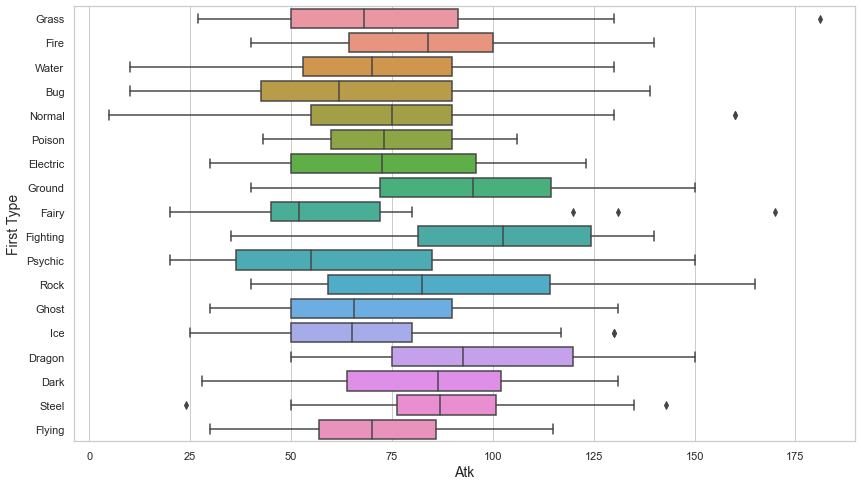

In [45]:
f, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(x = pokemonMaster_df["Atk"], y =  pokemonMaster_df["Type1"])
plt.xlabel("Atk", fontsize = 14)
plt.ylabel("First Type", fontsize = 14)
plt.savefig("../figures/boxplot_type_atk.pdf")

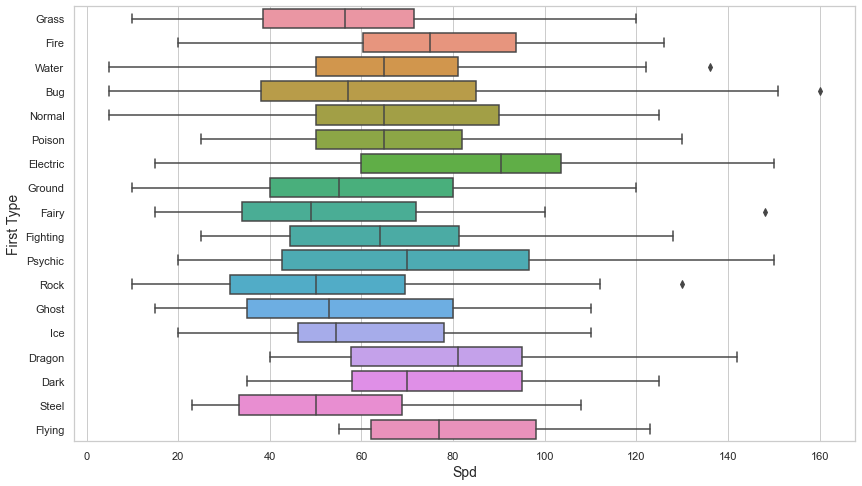

In [46]:
f, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(x = pokemonMaster_df["Spd"], y =  pokemonMaster_df["Type1"])
plt.xlabel("Spd", fontsize = 14)
plt.ylabel("First Type", fontsize = 14)
plt.savefig("../figures/boxplot_type_spd.pdf")

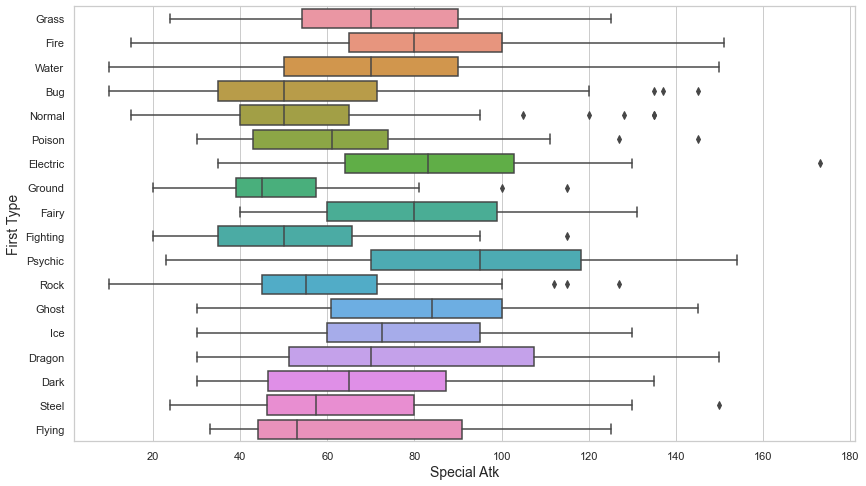

In [47]:
f, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(x = pokemonMaster_df["Satk"], y =  pokemonMaster_df["Type1"])
plt.xlabel("Special Atk", fontsize = 14)
plt.ylabel("First Type", fontsize = 14)
plt.savefig("../figures/boxplot_type_satk.pdf")

In [48]:
pokemonMaster_df[pokemonMaster_df["Satk"] == pokemonMaster_df["Satk"].max()]

,Dex,Name,Hp,Atk,Def,Satk,Sdef,Spd,Total,Height,...,Catchr,Gen,Female,Male,Femaler,Maler,Label,Type1,Type2,Genderless
795,796,Xurkitree,83,89,71,173,71,83,570,3.8,...,45.0,Sun,0,0,0.0,0.0,Semi-Legendary,Electric,None,True


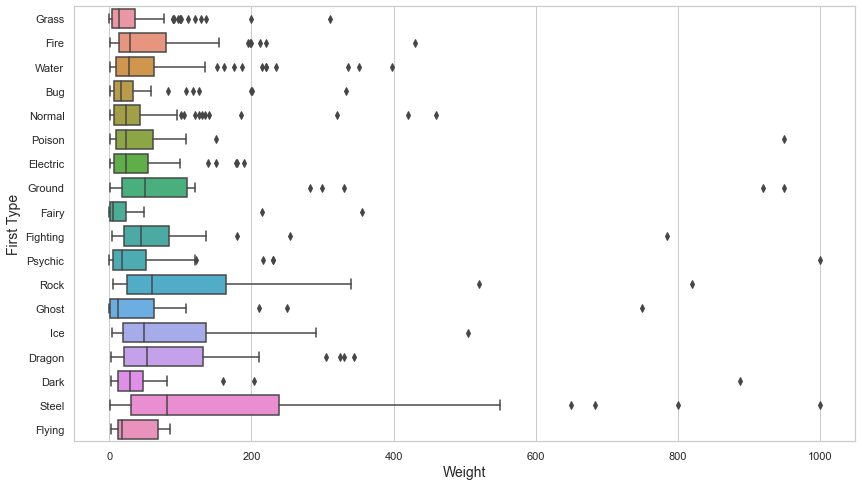

In [49]:
f, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(x = pokemonMaster_df["Weight"], y =  pokemonMaster_df["Type1"])
plt.xlabel("Weight", fontsize = 14)
plt.ylabel("First Type", fontsize = 14)
plt.savefig("../figures/boxplot_type_weight.pdf")

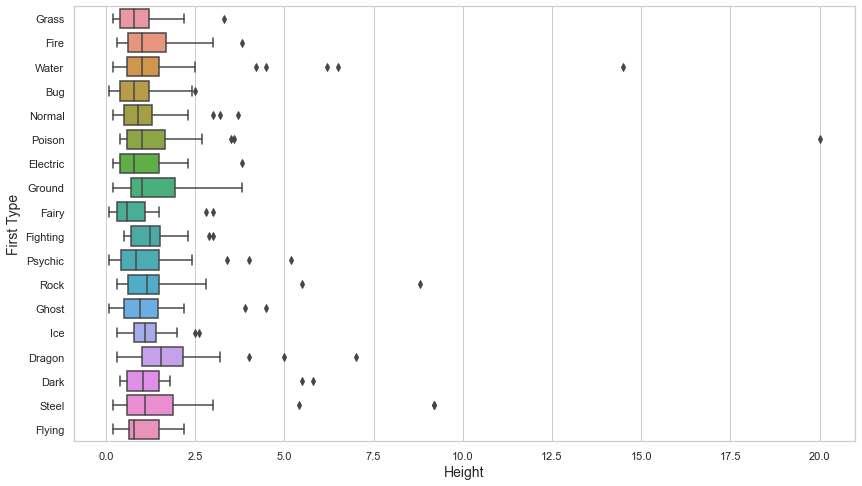

In [50]:
f, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(x = pokemonMaster_df["Height"], y =  pokemonMaster_df["Type1"])
plt.xlabel("Height", fontsize = 14)
plt.ylabel("First Type", fontsize = 14)
plt.savefig("../figures/boxplot_type_height.pdf")

In [51]:
pokemonMaster_df[pokemonMaster_df["Type1"] == "Dragon"].sort_values(by = "Height")

,Dex,Name,Hp,Atk,Def,Satk,Sdef,Spd,Total,Height,...,Catchr,Gen,Female,Male,Femaler,Maler,Label,Type1,Type2,Genderless
703,704,Goomy,45,50,35,55,75,40,300,0.3,...,45.0,X,1,1,50.0,50.0,Non Legendary,Dragon,None,False
884,885,Dreepy,28,60,30,40,30,82,270,0.5,...,-1.0,Sword,0,0,0.0,0.0,Non Legendary,Dragon,Ghost,True
609,610,Axew,46,87,60,30,40,57,320,0.6,...,75.0,Black,1,1,50.0,50.0,Non Legendary,Dragon,None,False
370,371,Bagon,45,75,60,40,30,50,300,0.6,...,45.0,Ruby,1,1,50.0,50.0,Non Legendary,Dragon,None,False
781,782,Jangmo-o,45,55,65,45,45,45,300,0.6,...,45.0,Sun,1,1,50.0,50.0,Non Legendary,Dragon,None,False
442,443,Gible,58,70,45,40,45,42,300,0.7,...,45.0,Diamond,1,1,50.0,50.0,Non Legendary,Dragon,Ground,False
704,705,Sliggoo,68,75,53,83,113,60,452,0.8,...,45.0,X,1,1,50.0,50.0,Non Legendary,Dragon,None,False
610,611,Fraxure,66,117,70,40,50,67,410,1.0,...,60.0,Black,1,1,50.0,50.0,Non Legendary,Dragon,None,False
333,334,Altaria,75,70,90,70,105,80,490,1.1,...,45.0,Ruby,1,1,50.0,50.0,Non Legendary,Dragon,Flying,False
371,372,Shelgon,65,95,100,60,50,50,420,1.1,...,45.0,Ruby,1,1,50.0,50.0,Non Legendary,Dragon,None,False


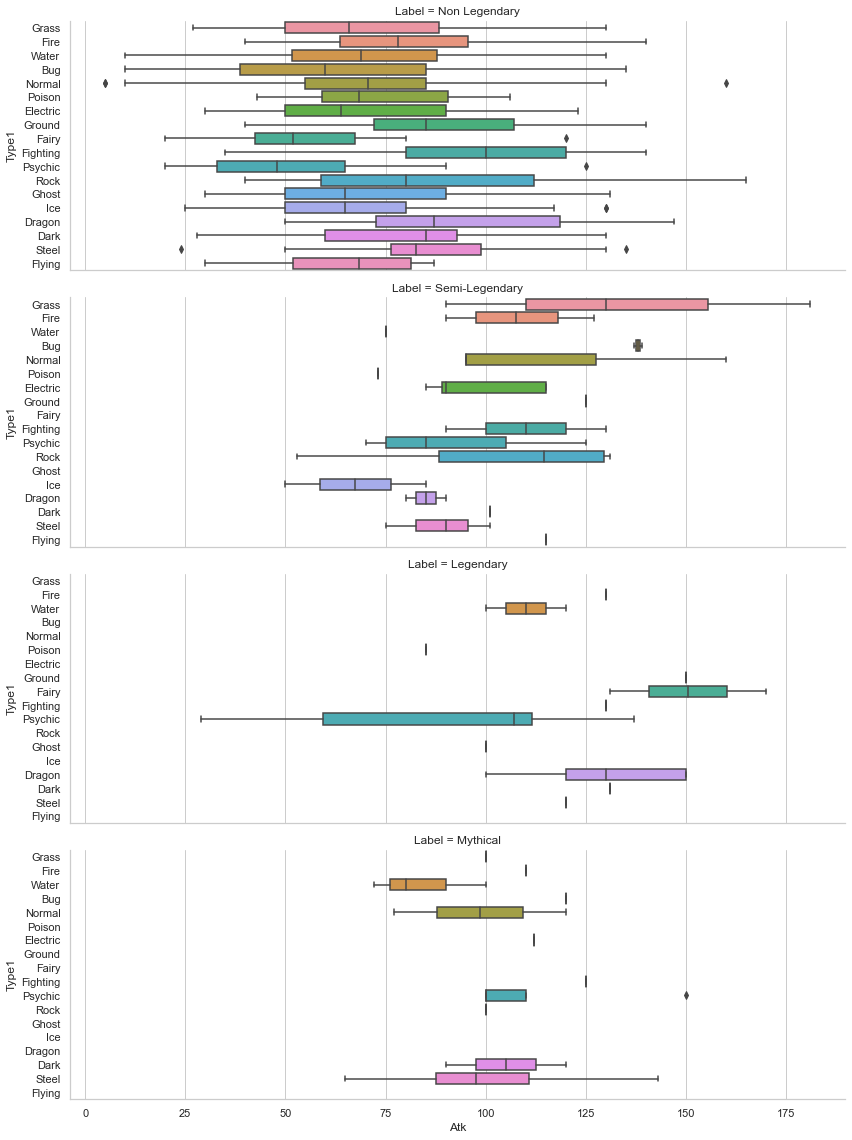

In [52]:
sns.catplot(x="Atk", y="Type1", row="Label",
                kind="box", orient="h", height=4, aspect=3,
                data=pokemonMaster_df)

D:\Master\Software\envs\pokemon_scrapy\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


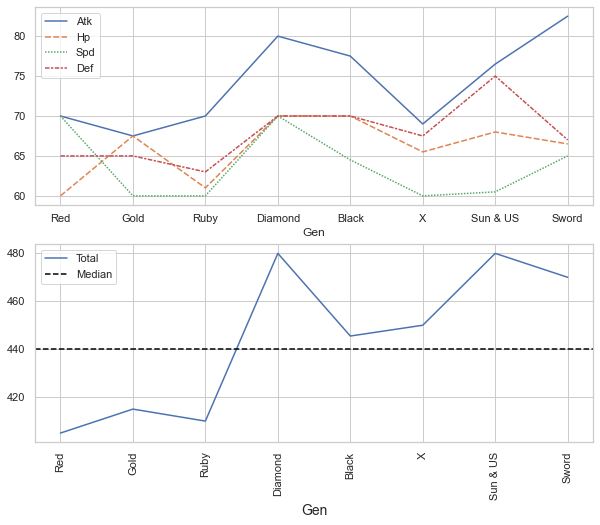

In [55]:
time_data = pokemonGender_df[pokemonGender_df["Gen"]!="Let's Go Pikachu"]
time_data.loc[time_data["Gen"] == "Ultra Sun", "Gen"] = "Sun & US"
time_data.loc[time_data["Gen"] == "Sun", "Gen"] = "Sun & US"

time_df = time_data[["Atk", "Hp", "Spd", "Def", "Gen"]].groupby("Gen", sort=False).median()

plt.figure(figsize=(10,8))
plt.subplot(211, )
ax = sns.lineplot(data=time_df, sort = False)
plt.subplot(212)
ax2 = sns.lineplot(data=time_data[["Total", "Gen"]].groupby("Gen", sort=False).median(), sort = False)
ax2.axhline(time_data["Total"].median(), ls='--', color = "black", label = "Median")
ax2.legend()
_, _ = plt.xticks(rotation = 90)

plt.xlabel("Gen", fontsize = 14)
plt.savefig("../figures/timeseries_stats.pdf")

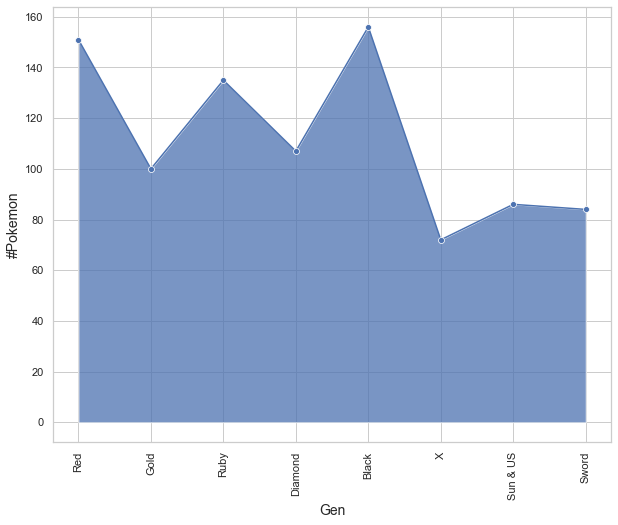

In [57]:
time_df = time_data[["Atk", "Gen"]].groupby("Gen", sort=False).count()

plt.figure(figsize=(10,8))
ax = sns.lineplot(data=time_df, sort = False, markers = True)
ax.get_legend().remove()



plt.fill_between(time_df.index.values, time_df.Atk.values, alpha = 0.75)



_, _ = plt.xticks(rotation = 90)

plt.xlabel("Gen", fontsize = 14)
plt.ylabel("#Pokemon", fontsize = 14)

plt.savefig("../figures/timeseries_pokemon.pdf")

In [58]:
tmp = pokemonMaster_df[["Label", "Total"]].groupby("Label").count().reset_index()
nlRatio = tmp["Total"].max() / tmp["Total"].sum()
print(f'Of {tmp["Total"].sum()} Pokemons {tmp["Total"].max()} are Non-Legendary. That is {nlRatio:.3f}%')

Of 893 Pokemons 806 are Non-egendary. That is 0.903%


In [59]:
pokemonMaster_df[(pokemonMaster_df["Type1"] == "Bug") & (pokemonMaster_df["Label"] != "Non Legendary")]

,Dex,Name,Hp,Atk,Def,Satk,Sdef,Spd,Total,Height,...,Catchr,Gen,Female,Male,Femaler,Maler,Label,Type1,Type2,Genderless
648,649,Genesect,71,120,95,120,95,99,600,1.5,...,3.0,Black,0,0,0.0,0.0,Mythical,Bug,Steel,True
793,794,Buzzwole,107,139,139,53,53,79,570,2.4,...,45.0,Sun,0,0,0.0,0.0,Semi-Legendary,Bug,Fighting,True
794,795,Pheromosa,71,137,37,137,37,151,570,1.8,...,45.0,Sun,0,0,0.0,0.0,Semi-Legendary,Bug,Fighting,True


In [60]:
pokemonMaster_df["genericLabel"] = pokemonMaster_df["Label"].apply(lambda x: "Non Legendary" if x == "Non Legendary" else "Legendary")

In [80]:
print(pokemonMaster_df.columns)
pokemonMaster_df.to_csv("../csv/pokemon.csv", index = False)

Index(['Dex', 'Name', 'Hp', 'Atk', 'Def', 'Satk', 'Sdef', 'Spd', 'Total',
       'Height', 'Weight', 'Growthr', 'Catchr', 'Gen', 'Female', 'Male',
       'Femaler', 'Maler', 'Label', 'Type1', 'Type2', 'Genderless',
       'genericLabel'],
      dtype='object')


In [62]:
type1_count = pokemonMaster_df[["genericLabel", "Type1", "Total"]].groupby(by = ["genericLabel", "Type1"]).count().reset_index()
type2_count = pokemonMaster_df[["genericLabel", "Type2", "Total"]].groupby(by = ["genericLabel", "Type2"]).count().reset_index()


type_count = type1_count.merge(type2_count, left_on = ["Type1", "genericLabel"], right_on = ["Type2", "genericLabel"], how = "outer")
type_count["Total_y"] = type_count["Total_y"].fillna(0)
type_count["Total"] = type_count["Total_x"] + type_count["Total_y"]

In [63]:
type_count

,genericLabel,Type1,Total_x,Type2,Total_y,Total
0,Legendary,Bug,3.0,NaN,0.0,3.0
1,Legendary,Dark,4.0,Dark,1.0,5.0
2,Legendary,Dragon,7.0,Dragon,6.0,13.0
3,Legendary,Electric,6.0,Electric,1.0,7.0
4,Legendary,Fairy,2.0,Fairy,6.0,8.0
5,Legendary,Fighting,4.0,Fighting,7.0,11.0
6,Legendary,Fire,6.0,Fire,3.0,9.0
7,Legendary,Flying,1.0,Flying,11.0,12.0
8,Legendary,Ghost,1.0,Ghost,4.0,5.0
9,Legendary,Grass,4.0,Grass,2.0,6.0


In [64]:
def f(x):
    return x[1] / nLabel.loc[x[0]]

nLabel = pokemonMaster_df[["genericLabel", "Total"]].groupby("genericLabel").count()
type_count["Rel"] = type_count[["genericLabel", "Total"]].apply(f, axis = 1)

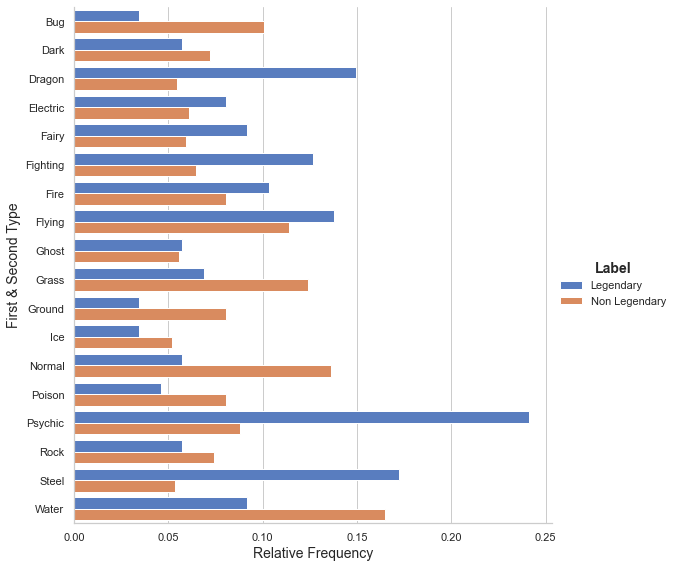

In [67]:
g = sns.catplot(y="Type1", x="Rel", hue="genericLabel", data=type_count,
                height=8, aspect = 1,  kind="bar", palette="muted")

g._legend.set_title("Label",  prop={'weight': "bold", "size" : 14})
g.set_ylabels("Type")
g.set_xlabels("Frequency")

plt.xlabel("Relative Frequency", fontsize = 14)
plt.ylabel("First & Second Type", fontsize = 14)
plt.savefig("../figures/types_label.pdf")

In [68]:
import pandas as pd
pd.crosstab(index=pokemonMaster_df['Label'], columns=pokemonMaster_df['Growthr'], margins = False).apply(lambda zeile: zeile/zeile.sum(), axis=1)

Growthr,Erratic,Fast,Fluctuating,Medium Fast,Medium Slow,Slow,—
Label,,,,,,,
Legendary,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000
Mythical,0.000000,0.000000,0.00000,0.000000,0.136364,0.818182,0.045455
Non Legendary,0.031017,0.076923,0.01737,0.460298,0.270471,0.143921,0.000000
Semi-Legendary,0.000000,0.000000,0.00000,0.000000,0.000000,0.952381,0.047619


In [69]:
pokemonMaster_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 893 entries, 0 to 892
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Dex           893 non-null    int64  
 1   Name          893 non-null    object 
 2   Hp            893 non-null    int64  
 3   Atk           893 non-null    int64  
 4   Def           893 non-null    int64  
 5   Satk          893 non-null    int64  
 6   Sdef          893 non-null    int64  
 7   Spd           893 non-null    int64  
 8   Total         893 non-null    int64  
 9   Height        893 non-null    float64
 10  Weight        893 non-null    float64
 11  Growthr       893 non-null    object 
 12  Catchr        893 non-null    float64
 13  Gen           893 non-null    object 
 14  Female        893 non-null    int64  
 15  Male          893 non-null    int64  
 16  Femaler       893 non-null    float64
 17  Maler         893 non-null    float64
 18  Label         893 non-null    

In [70]:
pokemonMaster_df.groupby("Label").mean()

,Dex,Hp,Atk,Def,Satk,Sdef,Spd,Total,Height,Weight,Catchr,Female,Male,Femaler,Maler,Genderless
Label,,,,,,,,,,,,,,,,
Legendary,607.173913,105.608696,114.434783,104.565217,114.652174,107.000000,95.913043,642.173913,4.295652,400.326087,26.217391,0.000000,0.000000,0.000000,0.000000,1.000000
Mythical,597.545455,88.000000,104.045455,96.136364,107.681818,95.590909,94.000000,585.454545,1.050000,83.068182,9.409091,0.000000,0.000000,0.000000,0.000000,1.000000
Non Legendary,430.504963,66.210918,73.339950,69.028536,65.630273,66.837469,62.821340,403.868486,1.051489,48.291067,96.359801,0.843672,0.832506,38.833747,47.410050,0.136476
Semi-Legendary,596.976190,87.595238,101.285714,96.595238,99.523810,94.619048,90.357143,569.976190,2.071429,169.290476,13.095238,0.071429,0.119048,5.952381,10.714286,0.833333


In [71]:
pokemonMaster_df.groupby("Label").median()

,Dex,Hp,Atk,Def,Satk,Sdef,Spd,Total,Height,Weight,Catchr,Female,Male,Femaler,Maler,Genderless
Label,,,,,,,,,,,,,,,,
Legendary,646.0,105.0,120.0,100.0,127.0,100.0,95.0,680.0,3.5,325.0,3.0,0.0,0.0,0.0,0.0,True
Mythical,647.5,90.5,100.0,100.0,100.0,97.5,100.0,600.0,0.7,15.6,3.0,0.0,0.0,0.0,0.0,True
Non Legendary,424.5,65.0,70.0,65.0,60.0,65.0,60.0,419.0,0.9,24.3,60.0,1.0,1.0,50.0,50.0,False
Semi-Legendary,641.5,81.5,95.0,90.0,95.0,95.0,95.0,580.0,1.8,76.8,3.0,0.0,0.0,0.0,0.0,True


In [72]:
pokemonMaster_df.groupby("Label").std()

,Dex,Hp,Atk,Def,Satk,Sdef,Spd,Total,Height,Weight,Catchr,Female,Male,Femaler,Maler,Genderless
Label,,,,,,,,,,,,,,,,
Legendary,224.712069,26.132076,34.061210,23.721540,36.578196,27.157788,25.025284,115.323912,3.781111,294.250112,53.725698,0.000000,0.000000,0.000000,0.000000,0.000000
Mythical,199.153620,21.891507,20.954548,24.470187,24.862261,25.430876,30.886890,73.854895,0.806373,177.041226,15.683352,0.000000,0.000000,0.000000,0.000000,0.000000
Non Legendary,256.603969,24.496270,28.197459,28.092136,26.398659,25.004092,26.620645,98.416330,0.906165,76.630577,77.302501,0.363391,0.373648,23.899797,26.229096,0.343507
Semi-Legendary,228.527683,26.372620,27.453984,35.447013,28.763322,32.387104,25.974492,42.918237,1.595311,233.785459,17.865090,0.260661,0.327770,22.638142,30.314840,0.377195


In [73]:
pd.crosstab(index=pokemonMaster_df['Label'], columns=pokemonMaster_df['Type1'], margins = False).apply(lambda zeile: zeile/zeile.sum(), axis=1)

Type1,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
Label,,,,,,,,,,,,,,,,,,
Legendary,0.000000,0.043478,0.217391,0.000000,0.086957,0.043478,0.043478,0.000000,0.043478,0.000000,0.043478,0.000000,0.000000,0.043478,0.304348,0.000000,0.043478,0.086957
Mythical,0.045455,0.090909,0.000000,0.045455,0.000000,0.045455,0.045455,0.000000,0.000000,0.045455,0.000000,0.000000,0.090909,0.000000,0.227273,0.045455,0.181818,0.136364
Non Legendary,0.089330,0.039702,0.028536,0.052109,0.023573,0.039702,0.064516,0.007444,0.035980,0.101737,0.040943,0.029777,0.129032,0.039702,0.050868,0.055831,0.027295,0.143921
Semi-Legendary,0.047619,0.023810,0.047619,0.119048,0.000000,0.047619,0.095238,0.023810,0.000000,0.071429,0.023810,0.047619,0.071429,0.047619,0.119048,0.095238,0.071429,0.047619


In [74]:
pd.crosstab(index=pokemonMaster_df['Label'], columns=pokemonMaster_df['Type2'], margins = False).apply(lambda zeile: zeile/zeile.sum(), axis=1)

Type2,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,None,Normal,Poison,Psychic,Rock,Steel,Water
Label,,,,,,,,,,,,,,,,,,,
Legendary,0.000000,0.000000,0.173913,0.043478,0.000000,0.043478,0.086957,0.173913,0.043478,0.000000,0.043478,0.043478,0.217391,0.000000,0.000000,0.000000,0.00000,0.130435,0.000000
Mythical,0.000000,0.000000,0.000000,0.000000,0.090909,0.045455,0.045455,0.045455,0.090909,0.090909,0.000000,0.000000,0.409091,0.000000,0.000000,0.090909,0.00000,0.045455,0.045455
Non Legendary,0.011166,0.032258,0.026055,0.008685,0.035980,0.024814,0.016129,0.106700,0.019851,0.022333,0.039702,0.022333,0.482630,0.007444,0.040943,0.037221,0.01861,0.026055,0.021092
Semi-Legendary,0.000000,0.023810,0.047619,0.000000,0.095238,0.119048,0.000000,0.142857,0.023810,0.000000,0.000000,0.000000,0.404762,0.000000,0.023810,0.047619,0.00000,0.071429,0.000000


In [76]:
unique_types = np.unique(type1)

In [77]:
def f(x):
    nlabels = pokemonMaster_df["Label"].value_counts()
    index = x.index
    
    return x / nlabels.loc[index]

type_comb = pd.crosstab(index=pokemonMaster_df['Label'], columns=[pokemonMaster_df['Type1'], pokemonMaster_df['Type2']], margins = False).apply(f)

for t in unique_types:
    print(f"Type 1: {t}")
    print()
    print(type_comb[t].to_string())
    print()
    print()

Type 1: Bug

Type2           Electric     Fairy  Fighting      Fire   Flying     Ghost     Grass    Ground      None    Poison   Psychic      Rock     Steel     Water
Label                                                                                                                                                    
Legendary       0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
Mythical        0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.045455  0.000000
Non Legendary   0.004963  0.002481  0.001241  0.002481  0.01737  0.001241  0.007444  0.001241  0.022333  0.013648  0.002481  0.003722  0.004963  0.003722
Semi-Legendary  0.000000  0.000000  0.047619  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000


Type 1: Dark

Type2             Dragon     Fairy  Fighting   

In [78]:
type_comb.sum(axis = 1)

Label
Legendary         1.0
Mythical          1.0
Non Legendary     1.0
Semi-Legendary    1.0
dtype: float64